### continuation of 013

### setup

In [1]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import IPythonConsole
# from rdkit.Chem.Draw import MolDrawing, DrawingOptions, MolToImage

from rdkit import RDLogger
lg = RDLogger.logger()
lg.setLevel(RDLogger.CRITICAL)

import numpy as np

from tqdm.notebook import tqdm
from tqdm.contrib.concurrent import process_map

import pandas as pd

RDKit WARNING: [12:53:44] Enabling RDKit 2019.09.3 jupyter extensions


In [2]:
def apply_amat(acid,acid_match,amine,amine_match,rmat):
    """
    needs the smarts of the acid and amine pre-defined. maybe an external dictionary.
    """
    # combine molecules and make a writable version
    both = Chem.CombineMols(acid,amine)
    bothW = Chem.RWMol(both)
    Chem.Kekulize(both,clearAromaticFlags=True)
    Chem.Kekulize(bothW,clearAromaticFlags=True)
    # get the indices for the acid and amine matches
    amine_atoms = both.GetSubstructMatch(group_dict[amine_match])
    acid_atoms = both.GetSubstructMatch(group_dict[acid_match])
    
    if not (amine_atoms and acid_atoms):
        print("substruct match not found")
        return
    # join the indices
    atom_list = amine_atoms + acid_atoms
    
    # go through the amat to find places where the change is not 0
    side_len = len(rmat)
    
    if side_len != len(atom_list):
        print("matrix length does not equal number of matched atoms")
        return
    for r in range(side_len):
        for c in range(r+1,side_len):
            bond_order_change = rmat[r][c]
            if bond_order_change != 0: 
                atom1 = atom_list[amat2ind[r]]
                atom2 = atom_list[amat2ind[c]]
                # get the current bond order
                current_bond = both.GetBondBetweenAtoms(atom1,atom2)
                if current_bond: 
                    current_bond_order = current_bond.GetBondTypeAsDouble()                            
                else: 
                    current_bond_order = 0

                
                new_bond_order = current_bond_order + bond_order_change
                
                if new_bond_order not in [0,1,2,3]:
                    return None
                # make bond changes
                
                bothW.RemoveBond(atom1,atom2)
                
                if new_bond_order > 0:
                    bothW.AddBond(atom1,atom2, bond_dict[new_bond_order])
                        
    try:
        Chem.SanitizeMol(bothW)

    except:
#         print("illegal structure")
        return None

    # may need to become smiles if we want to multitarget, as well as have fragments included.
    return bothW

# bb = apply_amat(ac, "ac3",am, "am2",rmat)

### encode basic acid and amine

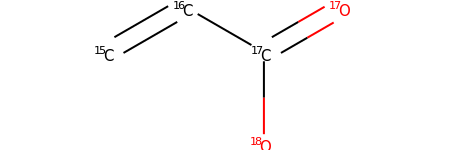

In [3]:
sp2_acid_smiles = '[17O]=[17C]([18O])[16C]=[15C]'
basic_acid = Chem.MolFromSmiles(sp2_acid_smiles)
basic_acid

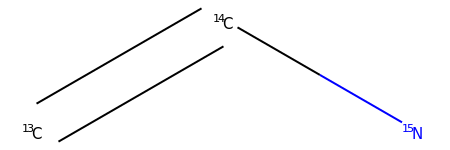

In [4]:
sp2_amine_smiles = "[15N][14C]=[13C]"
basic_amine = Chem.MolFromSmiles(sp2_amine_smiles)
basic_amine

In [5]:
am2 = Chem.MolFromSmarts("[13C]=[14C][15N]")
ac2 = Chem.MolFromSmarts("[15C]=[16C][17C](=[17O])[18O]")
am3 = Chem.MolFromSmarts("[13C][14C][15N]")
ac3 = Chem.MolFromSmarts("[15C][16C][17C](=[17O])[18O]")


group_dict = {"ac2":ac2, "ac3":ac3,"am2":am2,"am3":am3}
# the dictionary is basically like, first entry is amine C1. second entry is amine c2. 
# this changes depending on the matrix, and how the smarts for the matcher is written. 

# number of entries in the amat
amat_indices = range(8)
# which entry each index should map to
mapping_order = [0,1,3,4,5,2,6,7]
# mapping_order = [3,4,5,0,1,2,6,7]


# amat index -> amine/acid match index
amat2ind = {k:v for k,v in zip(amat_indices, mapping_order)}

bond_dict = {1:Chem.BondType.SINGLE, 2:Chem.BondType.DOUBLE, 3:Chem.BondType.TRIPLE}


### check that the substruct matching hits the right region

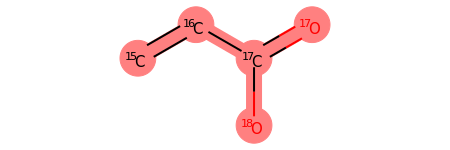

In [6]:
basic_acid.GetSubstructMatch(ac2)
basic_acid

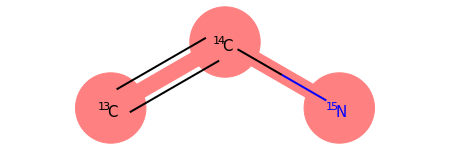

In [7]:
basic_amine.GetSubstructMatch(am2)
basic_amine

In [8]:
large_data = pd.read_csv("./ac2drug_am2small/ac2drug_am2small_aromatic.csv")

In [9]:
large_data.head()

,rmat_tag,distance,largest_frag,largest_cleaned
0,50231461,1.0,O=C(Cn1c(-c2ccccc2)c(C2CCCCC2)c2c[15c]([15N][1...,O=C(Cn1c(-c2ccccc2)c(C2CCCCC2)c2cc(Nc3cc(Cl)cc...
1,53844353,1.0,[15N][14c]1cc(Cl)cc(Cl)[13c]1-[15c]1cc2c(C3CCC...,Nc1cc(Cl)cc(Cl)c1-c1cc2c(C3CCCCC3)c(-c3ccccc3)...
2,50626702,1.0,[15N][14c]1cc(Cl)cc(Cl)[13c]1[18O][17C](=[17O]...,Nc1cc(Cl)cc(Cl)c1OC(=O)c1cc2c(cc1)c(C1CCCCC1)c...
3,50230203,1.0,O=C(Cn1c(-c2ccccc2)c(C2CCCCC2)c2c[15c][16c]([1...,O=C(Cn1c(-c2ccccc2)c(C2CCCCC2)c2ccc(C(=O)ONc3c...
4,53844354,2.0,O=C(Cn1c(-c2ccccc2)c(C2CCCCC2)c2c[15c]3[16c](c...,O=C(Cn1c(-c2ccccc2)c(C2CCCCC2)c2cc3c(cc21)C(=O...


In [10]:
valid_rmat_inds = np.array(list(large_data.rmat_tag))
valid_rmat_inds.sort()

In [11]:
large_data.sort_values("rmat_tag",inplace=True)
large_data.head(3)

,rmat_tag,distance,largest_frag,largest_cleaned
7024,36909919,11.0,O=C(Cn1c(-c2ccccc2)c(C2CCCCC2)c2c[15c][16c]([1...,O=C(Cn1c(-c2ccccc2)c(C2CCCCC2)c2ccc(OC3=c4cc(C...
6306,36909943,10.0,O=C(Cn1c(-c2ccccc2)c(C2CCCCC2)c2c[15c][16c]([1...,O=C(Cn1c(-c2ccccc2)c(C2CCCCC2)c2ccc(OC3=c4cc(C...
7114,36909947,12.0,O=C(Cn1c(-c2ccccc2)c(C2CCCCC2)c2c[15c][16c]([1...,O=C(Cn1c(-c2ccccc2)c(C2CCCCC2)c2ccc(OOC3=c4cc(...


### compile which parts of the 8-atom reaction center are in the coupled product

In [12]:
acid_parts = ["[15C]","[16C]","[17C]","[15c]","[16c]","[17c]","[17O]","[18O]","[17o]","[18o]"]
amine_parts = ["[13C]","[14C]","[13c]","[14c]","[15N]","[15n]"]

frags = []
for s in tqdm(list(large_data.largest_frag)):
    frags.append([i for i in acid_parts+amine_parts if i in s])

  0%|          | 0/7240 [00:00<?, ?it/s]

In [13]:
def run_enumeration(file_ind):
    index_start = file_ind * 1000000
    index_end = (file_ind+1) * 1000000

    valid_ind_locs = np.where(np.logical_and(valid_rmat_inds>= index_start,valid_rmat_inds < index_end))[0]

    # get the rmat inds needed
    rmat_inds_to_use = valid_rmat_inds[valid_ind_locs]

    # the local index for that particular file.
    rmat_inds_local = rmat_inds_to_use - file_ind * 1000000
    # rmat_inds_to_use is the true rmat_tag


    file_tag = str(file_ind).zfill(2)
    dmats = np.load(f"../rxn_mats/dmats_ac2_am2_{file_tag}.npy")
    dmats_to_use = dmats[rmat_inds_local]

    out_file = open(f"./ac2drug_am2small/rxn_center_only_{file_tag}.csv","w")
    out_file.write("rmat_tag,pdt_smiles\n")
    for i,dmat in enumerate(dmats_to_use):


#         matrix_index = rmat_inds_to_use[i]
#         m = apply_amat(basic_acid,"ac2",basic_amine,"am2",dmat)
#         s = Chem.MolToSmiles(m,isomericSmiles=True)
#         out_file.write(s+"\n")
        try:
            matrix_index = rmat_inds_to_use[i]
            m = apply_amat(basic_acid,"ac2",basic_amine,"am2",dmat)
            s = Chem.MolToSmiles(m,isomericSmiles=True)
            out_file.write(f"{matrix_index},{s}\n")

        except:
            continue

    out_file.close()


In [14]:
run_range = range(56)
# run_range = np.arange(0,56,5)

In [15]:
for i in run_range:
    run_enumeration(i)

In [18]:
small_pd = pd.concat([pd.read_csv(f"./ac2drug_am2small/rxn_center_only_{str(i).zfill(2)}.csv") for i in range(56)])

In [19]:
def count_atoms(s):
    alphab = "CONcon"
    return len([i for i in s if i in alphab]) 

def clean_structure(s):
    temp = s
    
    for i in acid_parts + amine_parts:
        temp = temp.replace(i,i[-2])
    return temp

In [ ]:
# make all the letters capital

In [21]:
relev_all = []
for i_s,s in tqdm(enumerate(small_pd.pdt_smiles)):
    split_s = s.split(".")
    
    # consider both aromatic and non-aromatic
    frg = frags[i_s]
    frg += [i.upper() for i in frg]
    
    relev_part = []
    for ss in split_s:
        if any([i in ss for i in frg]):
            relev_part.append(ss)
    
    if len(relev_part) > 1:
        atom_counts = [count_atoms(r) for r in relev_part]
        max_atom_ind = np.argmax(atom_counts)
        relev_part = relev_part[max_atom_ind]
        
    try:
        relev_all.append(relev_part[0])
            
    except:
        print(frg)
        print(split_s)
        print()

0it [00:00, ?it/s]

In [22]:
small_pd["frag_in_large"] = relev_all
small_pd["pdt_cleaned"] = [clean_structure(s) for s in small_pd.frag_in_large]

In [23]:
small_pd.head()

,rmat_tag,pdt_smiles,frag_in_large,pdt_cleaned
0,36909919,[15C]=[16C][18O][17C]1=[14C][13C]=[15N]1.[17O],[15C]=[16C][18O][17C]1=[14C][13C]=[15N]1,C=COC1=CC=N1
1,36909943,[15C]=[16C][17O][17C]1=[14C][13C]=[15N][18O]1,[15C]=[16C][17O][17C]1=[14C][13C]=[15N][18O]1,C=COC1=CC=NO1
2,36909947,[15C]=[16C][17O][18O][17C]1=[14C][13C]=[15N]1,[15C]=[16C][17O][18O][17C]1=[14C][13C]=[15N]1,C=COOC1=CC=N1
3,36910003,[15C]=[16C][17C]1=[14C][13C]=[15N][18O]1.[17O],[15C]=[16C][17C]1=[14C][13C]=[15N][18O]1,C=CC1=CC=NO1
4,36910009,[15C]=[16C][17C]1=[14C][13C]=[15N][18O][17O]1,[15C]=[16C][17C]1=[14C][13C]=[15N][18O][17O]1,C=CC1=CC=NOO1


In [24]:
small_pd.to_csv("./ac2drug_am2small/ac2drug_am2small_rxn_centers.csv",index=False)